In [131]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report



In [132]:
from google.colab import files
uploaded = files.upload()

Saving Crop_recommendation.csv to Crop_recommendation (5).csv


In [133]:
# Load the dataset
import pandas as pd
df = pd.read_csv('Crop_recommendation.csv')

In [134]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


<Axes: >

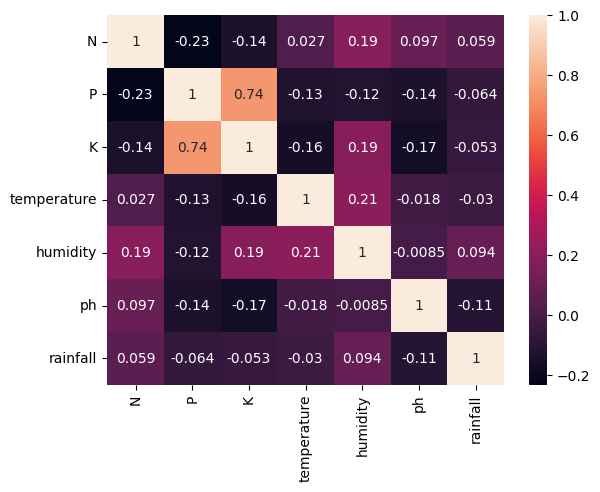

In [135]:
#Select only the numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Create the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True)

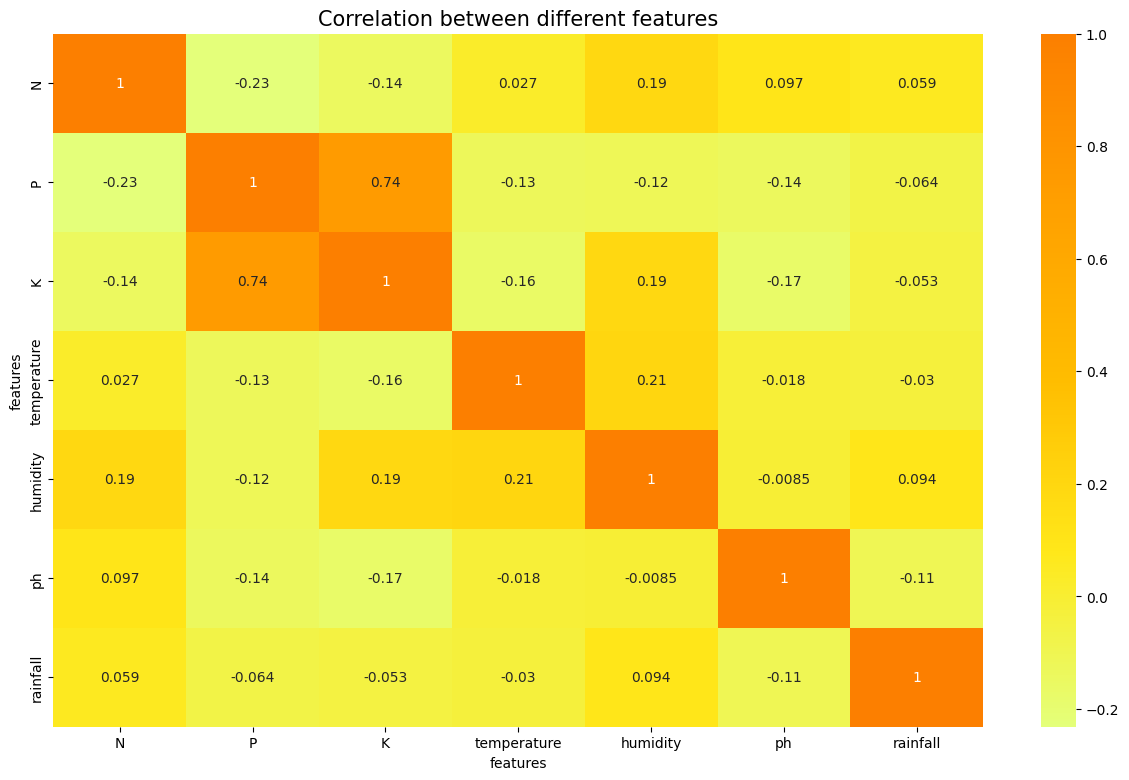

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
# Select only the numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Create the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True,cmap='Wistia')
ax.set(xlabel='features')
ax.set(ylabel='features')

plt.title('Correlation between different features', fontsize = 15, c='black')
plt.show()

In [137]:
# Encode the categorical labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [138]:
# Separate features and target
X = df.drop('label', axis=1)
y = df['label']

In [139]:
#Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [140]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [141]:
# Reshape data to fit LSTM requirements: (samples, timesteps, features)
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [142]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, input_shape=(1, X_train.shape[1])))
lstm_model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [143]:
# train lstm Model
history_lstm = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1472 - loss: 3.0581 - val_accuracy: 0.3722 - val_loss: 2.9405
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4356 - loss: 2.8912 - val_accuracy: 0.4972 - val_loss: 2.7471
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5283 - loss: 2.6849 - val_accuracy: 0.6080 - val_loss: 2.5042
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6293 - loss: 2.4171 - val_accuracy: 0.6506 - val_loss: 2.2337
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6695 - loss: 2.1349 - val_accuracy: 0.6932 - val_loss: 1.9612
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7039 - loss: 1.8501 - val_accuracy: 0.7244 - val_loss: 1.6967
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7414 - loss: 1.6176 - val_accuracy: 0.7301 - val_loss: 1.4607
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7588 - loss: 1.3894 - val_accuracy: 0.7727 - val_loss:

In [144]:
# Evaluate the LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9638 - loss: 0.1264  


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


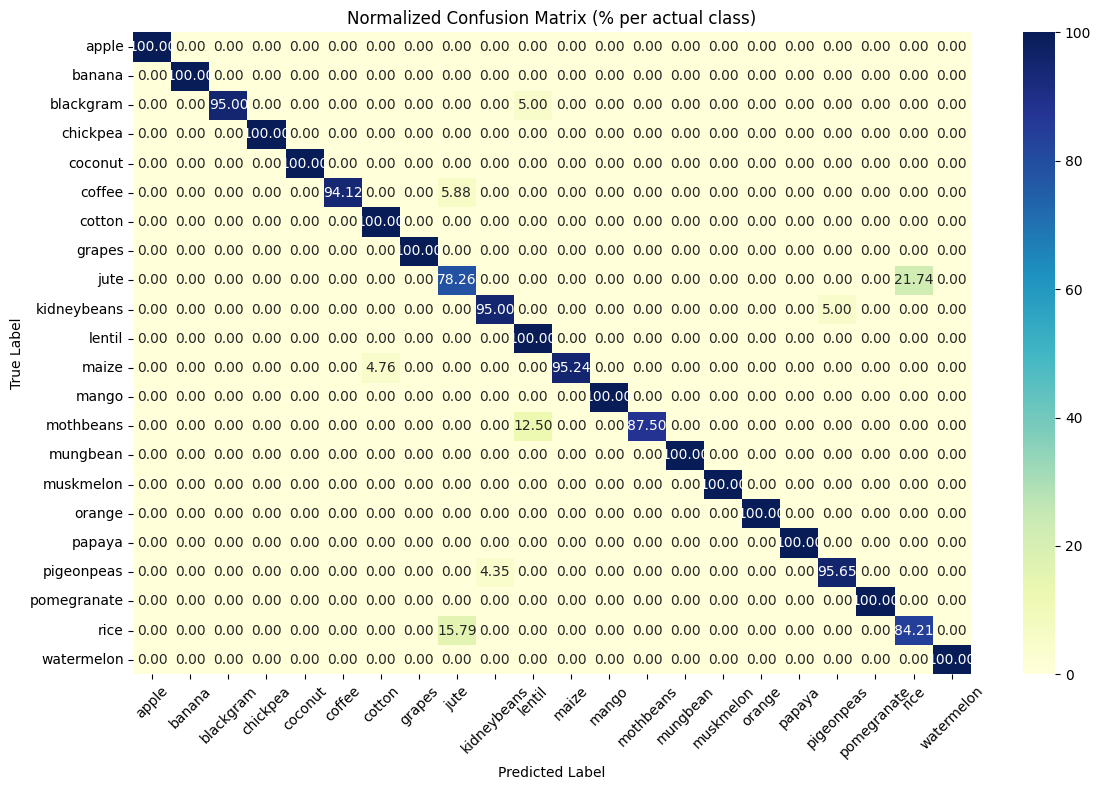

In [145]:
# Get predicted classes
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lstm)

# Normalize (row-wise)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_normalized * 100, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (% per actual class)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [146]:
# Reshape data to fit CNN-LSTM requirements: (samples, timesteps, features)
X_train_cnn_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [147]:
# Build the CNN-LSTM model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(units=50))
cnn_lstm_model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))
cnn_lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [148]:
# Train the CNN-LSTM model
history_cnn_lstm = cnn_lstm_model.fit(X_train_cnn_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0854 - loss: 3.0693 - val_accuracy: 0.0852 - val_loss: 2.9290
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1334 - loss: 2.7955 - val_accuracy: 0.2699 - val_loss: 2.4068
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3470 - loss: 2.1703 - val_accuracy: 0.6136 - val_loss: 1.6752
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6481 - loss: 1.4574 - val_accuracy: 0.7642 - val_loss: 1.1087
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8140 - loss: 0.9952 - val_accuracy: 0.7955 - val_loss: 0.8180
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8507 - loss: 0.7139 - val_accuracy: 0.8551 - val_loss: 0.6288
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8960 - loss: 0.5681 - val_accuracy: 0.8835 - val_loss: 0.5205
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9001 - loss: 0.4864 - val_accuracy: 0.9006 - val_loss:

In [149]:
# Evaluate the CNN-LSTM model
cnn_lstm_loss, cnn_lstm_accuracy = cnn_lstm_model.evaluate(X_test_cnn_lstm, y_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9700 - loss: 0.0912  


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


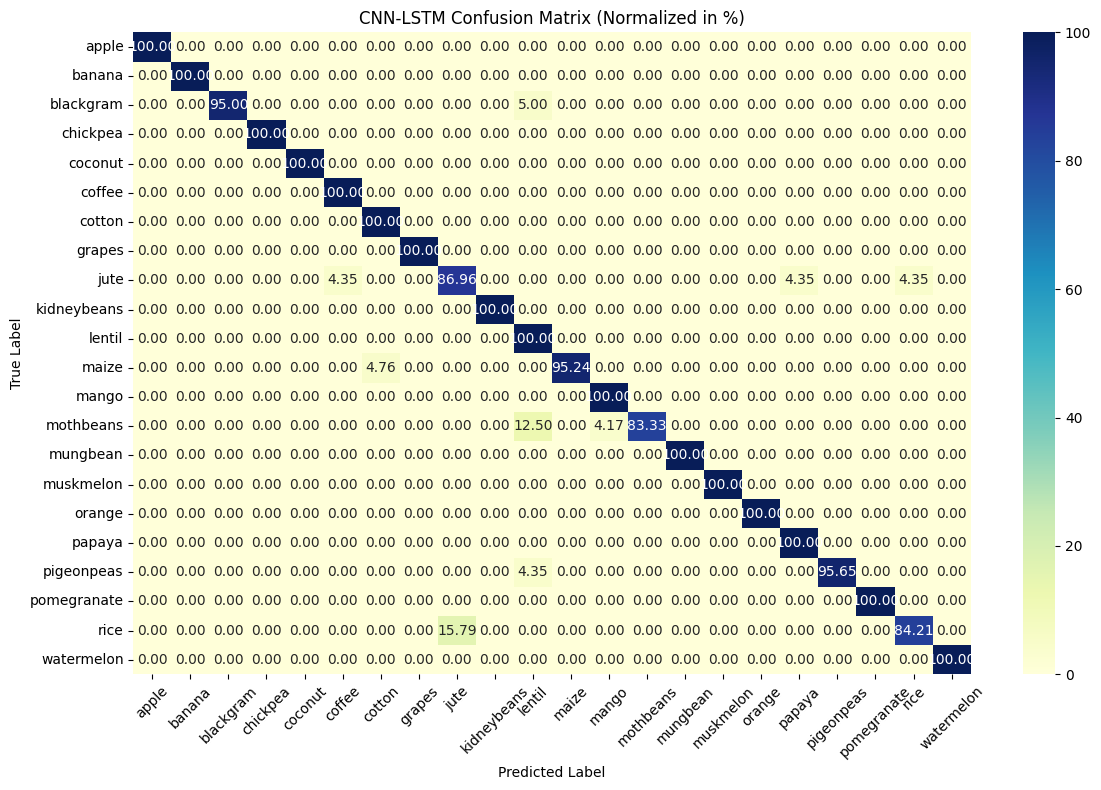

In [150]:
# 1. Predict class labels for the test set
y_pred_cnn_lstm = np.argmax(cnn_lstm_model.predict(X_test_cnn_lstm), axis=1)

# 2. Generate the raw confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_cnn_lstm)

# 3. Normalize the confusion matrix (row-wise: by true labels)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 4. Plot the normalized confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_norm * 100, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN-LSTM Confusion Matrix (Normalized in %)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [151]:
# Train-test split (again, just to be sure)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(random_state=42)

In [152]:
y_pred_rf = rf_model.predict(X_test_rf)

# Accuracy
from sklearn.metrics import accuracy_score
rf_accuracy = accuracy_score(y_test_rf, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.9932


In [153]:
# Classification Report
print("Random Forest Classification Report:")
print(classification_report(y_test_rf, y_pred_rf, target_names=label_encoder.classes_))


Random Forest Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00 

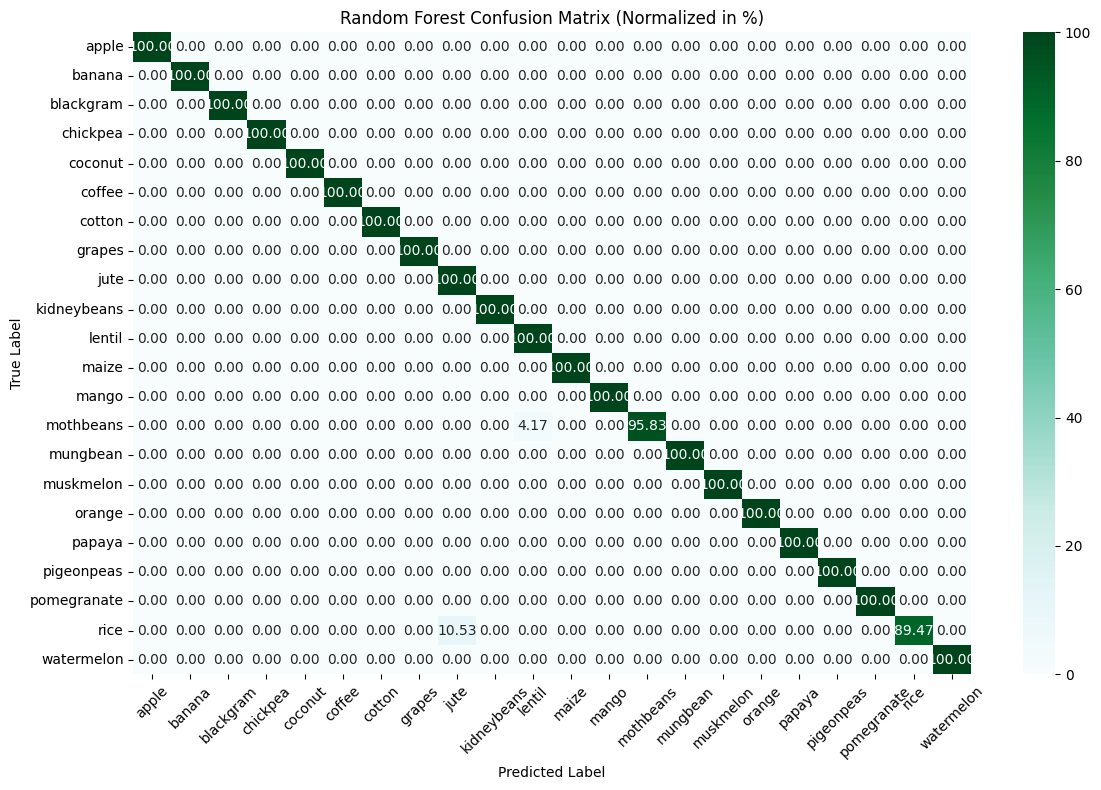

In [154]:
# Confusion Matrix (normalized)
conf_matrix_rf = confusion_matrix(y_test_rf, y_pred_rf)
conf_matrix_rf_norm = conf_matrix_rf.astype('float') / conf_matrix_rf.sum(axis=1)[:, np.newaxis]
# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_rf_norm * 100, annot=True, fmt='.2f', cmap='BuGn',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Random Forest Confusion Matrix (Normalized in %)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [155]:
# Use the same train-test split as Random Forest
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_rf, y_train_rf)

LogisticRegression(max_iter=1000, random_state=42)

In [156]:
# Predict
y_pred_log = log_model.predict(X_test_rf)

# Accuracy
from sklearn.metrics import accuracy_score
log_accuracy = accuracy_score(y_test_rf, y_pred_log)
print(f"Logistic Regression Accuracy: {log_accuracy:.4f}")


Logistic Regression Accuracy: 0.9636


In [157]:
# Classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test_rf, y_pred_log, target_names=label_encoder.classes_))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       0.90      0.95      0.93        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       0.94      1.00      0.97        17
      cotton       0.94      1.00      0.97        17
      grapes       1.00      1.00      1.00        14
        jute       0.83      0.87      0.85        23
 kidneybeans       0.95      0.95      0.95        20
      lentil       0.85      1.00      0.92        11
       maize       1.00      0.95      0.98        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.92      0.96        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00     

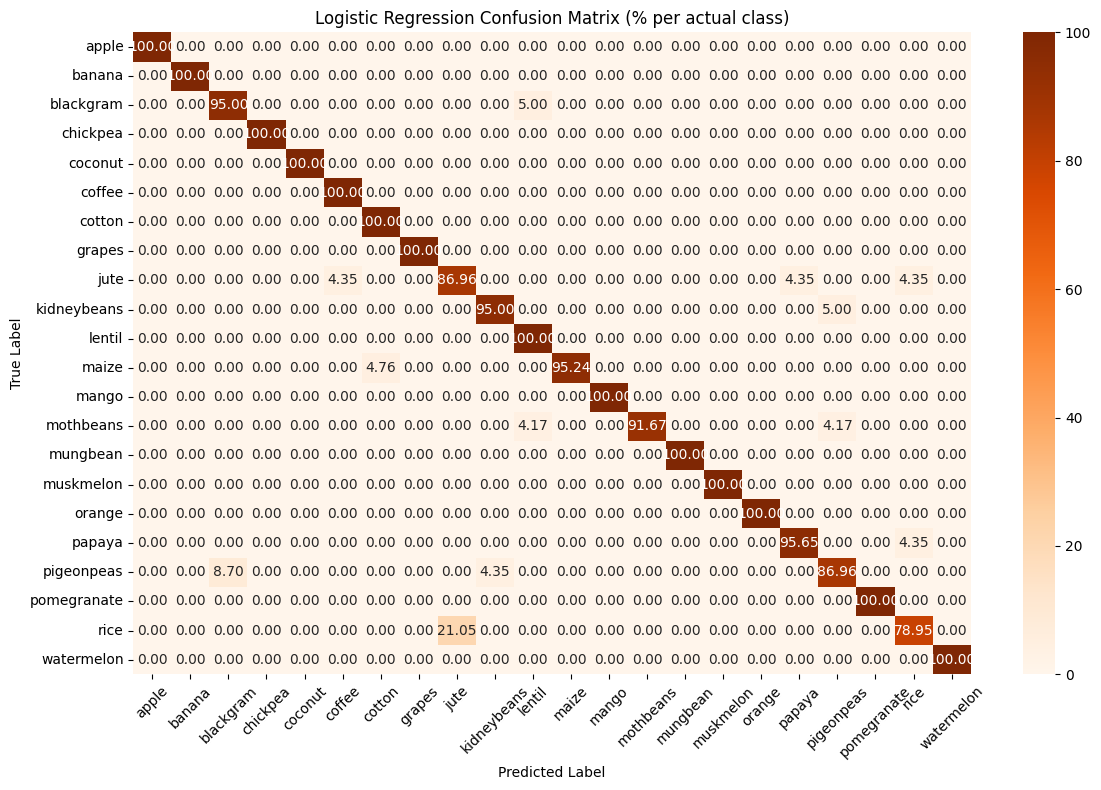

In [158]:
# Confusion matrix
conf_matrix_log = confusion_matrix(y_test_rf, y_pred_log)
conf_matrix_log_norm = conf_matrix_log.astype('float') / conf_matrix_log.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_log_norm * 100, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.title("Logistic Regression Confusion Matrix (% per actual class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [159]:
# Initialize and train
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_rf, y_train_rf)

DecisionTreeClassifier(random_state=42)

In [160]:
# Predict
y_pred_dt = dt_model.predict(X_test_rf)

# Accuracy
from sklearn.metrics import accuracy_score
dt_accuracy = accuracy_score(y_test_rf, y_pred_dt)
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")

Decision Tree Accuracy: 0.9864


In [161]:
# Classification report
print("Decision Tree Classification Report:")
print(classification_report(y_test_rf, y_pred_dt, target_names=label_encoder.classes_))

Decision Tree Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        26
     coconut       0.96      1.00      0.98        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      0.96      0.94        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      0.95      0.98        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.92      0.96        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00 

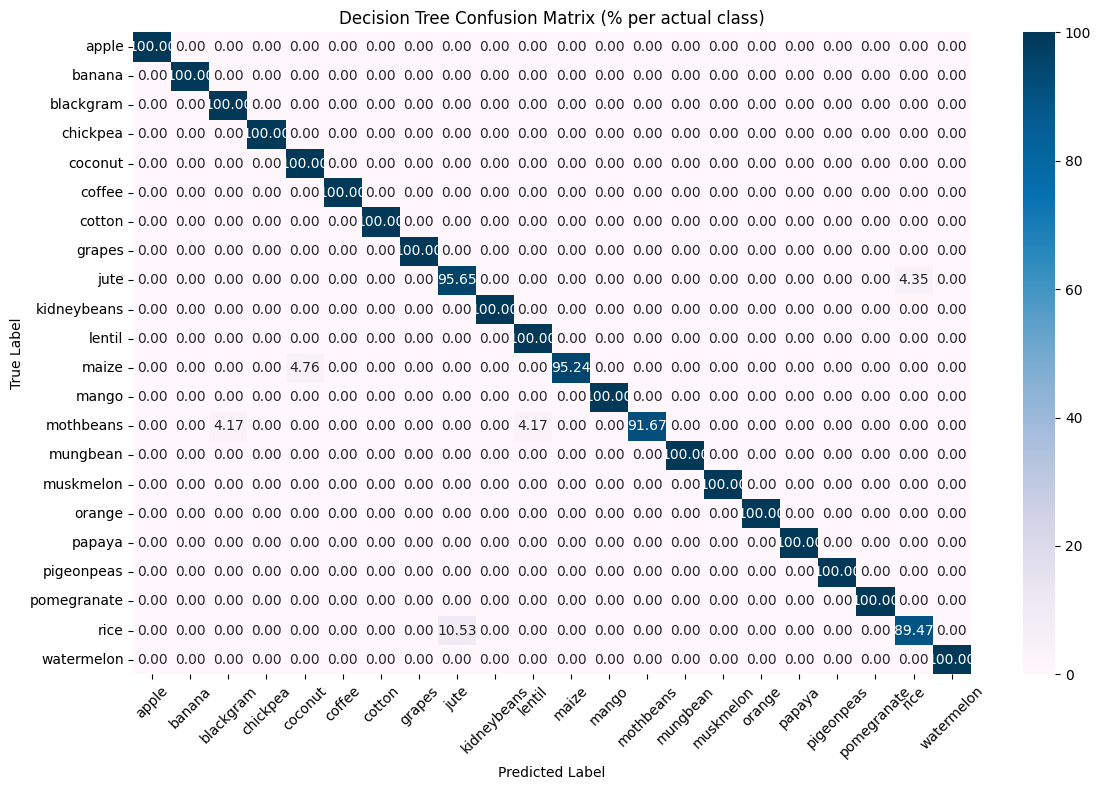

In [162]:
# Confusion matrix
conf_matrix_dt = confusion_matrix(y_test_rf, y_pred_dt)
conf_matrix_dt_norm = conf_matrix_dt.astype('float') / conf_matrix_dt.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_dt_norm * 100, annot=True, fmt='.2f', cmap='PuBu',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.title("Decision Tree Confusion Matrix (% per actual class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [163]:
print(f"""
Model Comparison:
-------------------------------
Logistic Regression : {log_accuracy:.4f}
Random Forest       : {rf_accuracy:.4f}
Decision Tree       : {dt_accuracy:.4f}
LSTM                : {lstm_accuracy:.4f}
CNN-LSTM            : {cnn_lstm_accuracy:.4f}
""")



Model Comparison:
-------------------------------
Logistic Regression : 0.9636
Random Forest       : 0.9932
Decision Tree       : 0.9864
LSTM                : 0.9636
CNN-LSTM            : 0.9705



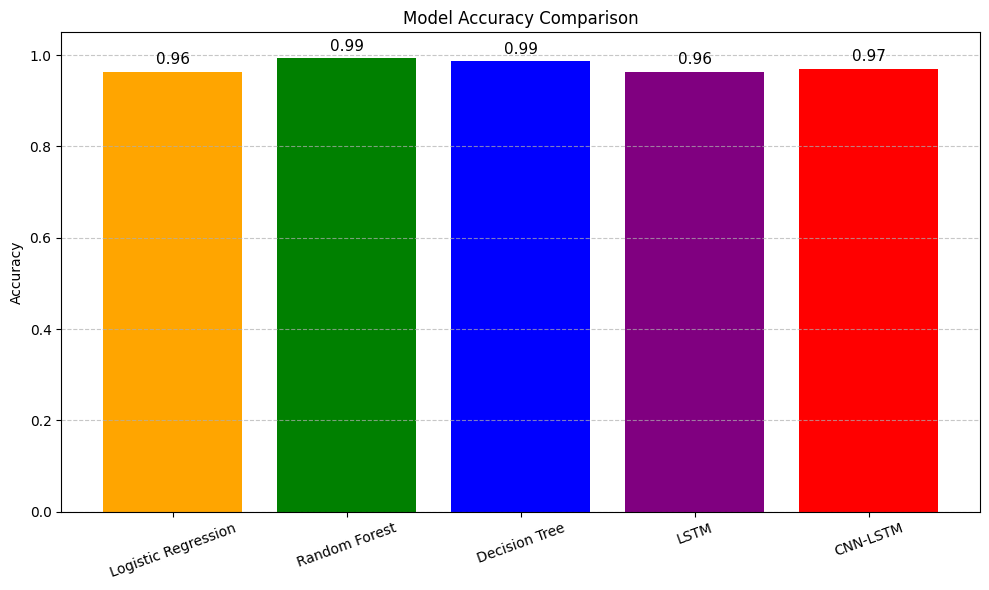

In [164]:
import matplotlib.pyplot as plt

# Model names and accuracies
model_names = ['Logistic Regression', 'Random Forest', 'Decision Tree', 'LSTM', 'CNN-LSTM']
accuracies = [log_accuracy, rf_accuracy, dt_accuracy, lstm_accuracy, cnn_lstm_accuracy]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['orange', 'green', 'blue', 'purple', 'red'])

# Add accuracy values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom', fontsize=11)

# Chart styling
plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
